In [173]:
from os import environ
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [172]:
#environ['datasets'] = 'clean_data/product.pkl clean_data/product_class.pkl clean_data/promotion.pkl clean_data/transactions.pkl'
dataset_paths = ['../' + dataset for dataset in environ['datasets'].split()]
product, product_class, promotion, transactions = [pd.read_pickle(path) for path in dataset_paths]


## Why a sanity check?
Before we get started on core analysis, we need to sanity check the data - check for missing values, measurement problems, and joining issues - and take a peek at how the variables are distributed.

This prepatory work will allow us to catch and fix data problems, correctly interpret our results, and guide the rest of the analysis.


## Where does this data come from?
The Foodmart data appears to have been drawn from a data warehouse: there is a central fact table of transactions, and dimension tables for products, product families, and promotions.

Some quick context is in order: in Data Warehouse "star schemas", fact tables store the measurements collected during particular business processes events - in this case, barcode scanning during supermarket checkout. 

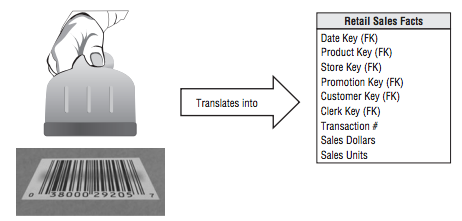

In [174]:
Image(filename='measurement_event.png') 

*Source: [The Data Warehouse Toolkit](http://www.essai.rnu.tn/Ebook/Informatique/The%20Data%20Warehouse%20Toolkit,%203rd%20Edition.pdf) by Ralph Kimball*

Each fact consists of a physical, real-valued *measurement* - the sales price of the product being purchased, in this case - and a set of foreign keys referring to dimension tables. Dimension tables capture the *context* around the measurement - the who, what, where, and when. (For the curious, data warehouses use star schemas because they are more intuitive for analysts and performant for aggregate queries.)

Generally, if an organization has gone through the trouble of designing a warehouse and ETL'ing data from dozens of operational systems into it, they've also made sure that events are being measured correctly and reliably, and that the fact tables satisfy *referential integrity* - that every foreign key in the fact table can be matched to a primary key in the dimension table. In other words, that no measurements are missing context. The data cleaning we had to do raises some red flags, however, so we better kick the tires.

Since transactions are the heart of everything, we'll look at them first. For each table, we'll look count the number of records, overall and grouped by variable.


## Transactions

How many transactions are there?

In [82]:
num_transactions = transactions.shape[0]
num_transactions

173602

Are any of the variables missing values?

In [52]:
transactions.isnull().sum()

product_id       0
customer_id      0
store_id         0
promotion_id     0
month_of_year    0
quarter          0
the_year         0
store_sales      0
store_cost       0
unit_sales       0
fact_count       0
dtype: int64

Lookin' good! None of our columns have missing values. We're not missing any sales price, cost, or unit measurements, and none of our foreign keys are missing!

Right?

Wait... what if some of our numerical values are just using "0" to represent null values? Let's count the number of 0's for all of our numerical variables:

In [81]:
dtypes = transactions.dtypes
numerical_cols = dtypes[(dtypes == 'float64') | (dtypes == 'int64')].index
num_0_values_by_col = (transactions[numerical_cols] == 0).sum()
num_0_values_by_col

product_id           0
customer_id      63627
store_id             0
promotion_id     63627
month_of_year        0
the_year             0
store_sales          0
store_cost           0
unit_sales           0
fact_count           0
dtype: int64

Uh oh, looks like both promotions and customers have 63,627 missing values! What percentage the transactions does this represent?

In [83]:
num_0_values_by_col['customer_id']/num_transactions

0.36651075448439535

Over a third of the dataset! How can this be?

For promotions, 0 probably represents "null" - it makes sense that one in three transactions did not occur through a promotion. For customers, however, either third of transaction are missing customers, or 1 in 3 transactions were performed by a single customer, which doesn't make sense.

It's striking, however, that the `promotion_id` and `customer_id` columns have the same number of 0 values. Maybe null promotions are associated with "0" customer_ids? This could point to a data collection problem.

In [163]:
zero_customer = transactions[transactions.customer_id == 0].index
zero_promotion = transactions[transactions.promotion_id == 0].index
set(zero_customer) & set(zero_promotion)

set()

Nope! There is not a single transactions where `promotion_id` and `customer_id` are both 0. This is very strange, considering the have the same exact number of 0 values.

Let's make a note of this and move on.

## Customers
How many unique customers are there, excluding the duds?

In [116]:
transactions_with_customers = transactions[~(transactions.customer_id == 0)]
unique_customers = transactions_with_customers.customer_id.nunique()
unique_customers

5652

How many transactions are there per customer?

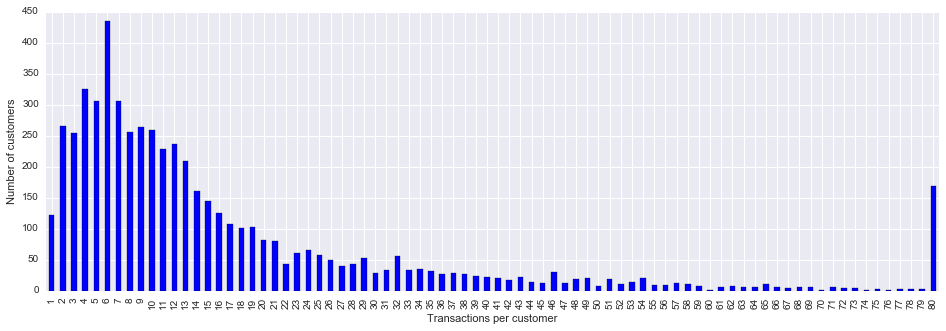

In [170]:
transactions_per_customer = transactions_with_customers.groupby('customer_id').size().clip(upper=80)
plt.figure(figsize=(16,5))
transactions_per_customer.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Transactions per customer')
plt.ylabel('Number of customers')

In [171]:
transactions_per_customer.describe()

count    5652.000000
mean       16.697452
std        17.360994
min         1.000000
25%         6.000000
50%        11.000000
75%        20.000000
max        80.000000
dtype: float64

Like many count datasets bounded a zero, the distribution of transactions per customer is right-skewed due to a very long. Half of customers purchased 11 products or less in 1997. More reports. (All values above 80 were pushed into 80.)

This makes sense: lots of people buy a couple things a few times, or a 8 things once. The quarter of people that shop there every week will buy some variable number of things each time, and end up somewhere random. There is a random variable of many things a person will buy with each visit - only items for express lane, or a whole cart full - and then there's the number of times they come per year. What we see is the multiplication of those two random variables.